In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import csv
import io
import pandas as pd
from scipy import interpolate
import scipy.optimize as opt
from scipy.interpolate import UnivariateSpline
   
from __future__ import print_function 
from scipy.optimize import curve_fit 

In [36]:
#Functions used later

def moku_read_spec(file_path):
    df = pd.read_csv(file_path,header=8)
    #print(df.to_string()) 
    x_data = df['% Frequency (Hz)']
    y_data1 = df[' Input A (dBV/rtHz)']
    y_data2 =df[' Input B (dBV/rtHz)']
    
    return x_data, y_data1, y_data2

#TF done on channel A
def moku_read_TF_A(file_path):
    df = pd.read_csv(file_path,header=7)
    #print(df.to_string()) 
    x_data = df['% Frequency (Hz)']
    y_data1 = df[' Channel A Magnitude (dB)']
    y_data2 =df[' Channel A Phase (deg)']
    	 	
    return x_data, y_data1, y_data2

#TF done on channel B
def moku_read_TF_B(file_path):
    df = pd.read_csv(file_path,header=7)
    #print(df.to_string()) 
    x_data = df['% Frequency (Hz)']
    y_data1 = df[' Channel B Magnitude (dB)']
    y_data2 =df[' Channel B Phase (deg)']
    	 	
    return x_data, y_data1, y_data2

def moku_read_Probe_Points(file_path):
    df = pd.read_csv(file_path,header=14)
    #print(df.to_string()) 
    x_data = df['% Time (s)']
    y_data1 = df[' Probe A (Probe A) (V)']
    y_data2 =df[' Probe B (Probe B) (V)']
    	 	
    return x_data, y_data1, y_data2

def db2mag(db):
    return 10**(db/20)

def mag2db(mag):
    return 20*np.log10(mag)

def remove_nan_rows(array):
    # Find indices of NaN values in the array

    nan_indices = pd.isnull(array)

    # Remove rows with NaN values
    array_without_nan = array[~nan_indices]
    print(nan_indices)
    # Return new array
    return array_without_nan

def interpt1d(data):
    x_data = data[0]
    y_data = data[1]
    
    new_func = interpolate.interp1d(x_data, y_data)
    return new_func

def interpt1d_phase(data):
    x_data = data[0]
    y_data = data[2]
    
    new_func = interpolate.interp1d(x_data, y_data)
    return new_func

def gauss(x, p): # p[0]==mean, p[1]==stdev
    return 1.0/(p[1]*np.sqrt(2*np.pi))*np.exp(-(x-p[0])**2/(2*p[1]**2))

def linear_windowing(array1, array2, start_index, end_index):
    # Check if the specified range is valid
    if start_index < 0 or end_index >= min(len(array1), len(array2)) or start_index >= end_index:
        raise ValueError("Invalid range specified")
    array1 = np.abs(array1)
    array2 = np.abs(array2)
    
    # Calculate the window size and create the linear windowing function
    window_size = end_index - start_index+1
    window = np.linspace(0, 1, window_size)
    # Create new arrays to store the modified values
    modified_array1 = np.copy(array1)
    modified_array2 = np.copy(array2)

    # Apply the linear windowing function to both new arrays
    modified_array1[start_index:end_index+1] = array1[start_index:end_index+1] * (1-window)
    modified_array2[start_index:end_index+1] = array2[start_index:end_index+1]*window 

    
    #hybrid = np.concatenate((array1[:start_index],modified_array1[start_index:end_index]+modified_array2[start_index:end_index],array2[end_index:]))
    hybrid = np.abs(modified_array1) + np.abs(modified_array2)

    return modified_array1,modified_array2,hybrid

def linear_windowing_phase(array1, array2, start_index, end_index):
    # Check if the specified range is valid
    if start_index < 0 or end_index >= min(len(array1), len(array2)) or start_index >= end_index:
        raise ValueError("Invalid range specified")

    # Calculate the window size and create the linear windowing function
    window_size = end_index - start_index+1
    window = np.linspace(0, 1, window_size)
    # Create new arrays to store the modified values
    modified_array1 = np.copy(array1)
    modified_array2 = np.copy(array2)

    # Apply the linear windowing function to both new arrays
    modified_array1[start_index:end_index+1] = array1[start_index:end_index+1] * (1-window)
    modified_array2[start_index:end_index+1] = array2[start_index:end_index+1]*window 

    
    #hybrid = np.concatenate((array1[:start_index],modified_array1[start_index:end_index]+modified_array2[start_index:end_index],array2[end_index:]))
    hybrid = modified_array1 + modified_array2

    return modified_array1,modified_array2,hybrid,array1,array2

def lowpass(order,ugf,pass_band_db,freqs):
    order = order
    ugf = ugf
    pass_band_db = pass_band_db
    gain = 10**(pass_band_db/20)
    wc = (ugf/(gain+1))
    #print("Cutoff Frequency for Fast Controller:",wc)

    new_freqs = freqs

    b, a = signal.butter(order, wc, 'low', analog=True)
    w, h1 = signal.freqs(b, a,worN=new_freqs)
    h1_dB = 60 + 20 * np.log10(abs(h1))
    
    return w, h1_dB, h1*1000
def find_FWHM(cavscan,scan_amp):
    
    peak = max(cavscan[1])
    index_max = np.argmax(cavscan[1])

    x_start = index_max - 25
    x_end = index_max + 25

    y_offset = np.average(cavscan[1])

    xdata = cavscan[0][x_start:x_end]
    ydata = cavscan[1][x_start:x_end]

    def lorentzian(x, amplitude, center, width):
        return amplitude / (1 + ((x - center) / (width/2))**2) + y_offset
    
    def Gauss(x, A, B): 
        y = A*np.exp(-1*B*(x-xdata[index_max])**2) + y_offset
        return y 
    initial_guess = [peak-y_offset, xdata[index_max], cavscan[0][x_end]-cavscan[0][x_start]]  # Initial guess for amplitude, center, and width
    params, covariance = curve_fit(lorentzian, xdata, ydata, p0=initial_guess)
    #parameters, covariance = curve_fit(lorentzian, xdata, ydata) 
    
    fit_A = params[0] 
    fit_B = params[1] 
    fit_C = params[2]

    finer_time = np.arange(cavscan[0][x_start],cavscan[0][x_end],.00001)

    fit_y = lorentzian(xdata, fit_A, fit_B,fit_C) 
    fit_y_fine = lorentzian(finer_time,fit_A,fit_B,fit_C)
    half_max_gauss = max(fit_y_fine-y_offset)/2

    
    spline = UnivariateSpline(finer_time, fit_y_fine-half_max_gauss-y_offset, s=0)
    r1, r2 = spline.roots() # find the roots

    FWHM = abs(r2-r1)

    #plt.plot(cavscan[0][x_start:x_end],cavscan[1][x_start:x_end]*1000,label = 'TRANS')
    #plt.ylabel('Amplitude (mV)')
    #plt.xlabel('Time (s)')
    #plt.xlim(0,.01)
    #plt.legend()
    plt.title('Calculating FWHM via cavity scan; measured on TRANS PD')
    plt.plot(xdata, ydata, 'o', label='data') 
    plt.plot(xdata, fit_y, '-') 
    plt.plot(finer_time,fit_y_fine,label='fit')
    plt.axvspan(r1, r2, facecolor='g', alpha=0.5)
    plt.legend()

    print("FWHM",FWHM)

    #convert FWHM in time to voltage to current to meters to frequency
    scan_freq = 10
    scan_amp = scan_amp
    miliamp_per_V = 2e-3
    meters_per_miliamp = 5e-12/20e-3
    cav_len = 2.4
    lambda_1 = 1550e-9
    c = 3e8

    FWHM_in_volts = FWHM * (2*scan_amp/(1/scan_freq))


    BW = (FWHM_in_volts*(miliamp_per_V)*(meters_per_miliamp)*(c/lambda_1**2))
    print("BW is:",BW)
    FSR = 125e6
    finesse = FSR/BW
    print("Finesse is:",finesse)

    error_max = max(cavscan[2])
    error_min = min(cavscan[2])
    error_amp = error_max-error_min

    # plt.figure(2)
    # plt.title("Cavity Error Signal for Amplitude Calculation")
    # plt.ylabel('Amplitude (mV)')
    # plt.xlabel('Time (s)')
    # plt.plot(cavscan[0],cavscan[2]*1000,label = 'error signal')
    # plt.show()
    
    return FWHM,BW,finesse,error_amp

def calc_cav_piezo(cavscan,clg,HV,noHV,scan_amp,order,ugf,pass_band_db):
    
    cavscan = cavscan
    scan_amp = scan_amp
    FSR = 125e6
    FWHM,BW,finesse,error_amp = find_FWHM(cavscan,scan_amp)
    order = order
    ugf = ugf
    pass_band_db = pass_band_db
    new_freqs = np.arange(1000,100000,1)

    w, h1_dB, h1 = lowpass(order,ugf,pass_band_db,new_freqs)
    

    cavityPiezoNoHV = noHV
    cavityPiezowHV = HV
    cavitylaserCLG = clg
    
    #interpolate data so math can be done

    cavityPiezoNoHV_inter = interpt1d(cavityPiezoNoHV)
    cavityPiezowHV_inter = interpt1d(cavityPiezowHV)
    cavitylaserCLG_inter = interpt1d(cavitylaserCLG)


    cavityPiezoNoHV_inter_phase = interpt1d_phase(cavityPiezoNoHV)
    cavityPiezowHV_inter_phase = interpt1d_phase(cavityPiezowHV)
    cavitylaserCLG_inter_phase = interpt1d_phase(cavitylaserCLG)

    noHV_complex = db2mag(cavityPiezoNoHV_inter(new_freqs))*np.exp(1j*cavityPiezoNoHV_inter_phase(new_freqs)*np.pi/180.)
    wHV_complex = db2mag(cavityPiezowHV_inter(new_freqs))*np.exp(1j*cavityPiezowHV_inter_phase(new_freqs)*np.pi/180.)
    CLG_complex = db2mag(cavitylaserCLG_inter(new_freqs))*np.exp(1j*cavitylaserCLG_inter_phase(new_freqs)*np.pi/180.)

    #Do calculation without hybridizing for comparison 
    h_p_HV = wHV_complex/CLG_complex/((h1)*(error_amp/BW))/FSR
    h_p_no_HV = noHV_complex/CLG_complex/((h1)*(error_amp/BW))/FSR

    h_p_HV_phase= np.angle(h_p_HV,deg = True)
    h_p_HV_amp = np.abs(h_p_HV)

    h_p_no_HV_phase= np.angle(h_p_no_HV,deg = True)
    h_p_no_HV_amp = np.abs(h_p_no_HV)
    
    M1 = CLG_complex
    G = (M1-1)/M1

    # create fast controller at low frequencies
    low_freqs = np.arange(1,10000)

    w, h2_db, h2_complex = lowpass(order,ugf,pass_band_db,low_freqs)

    new_freqs = np.arange(1000,100000,1)

    # Create window for hybrid
    f1 = low_freqs[0]
    f2 = low_freqs[-1]
    f3 = new_freqs[0]
    f4 = new_freqs[-1]

    G_zeroes = np.array([0]*(f3-f1))
    h2_zeroes = np.array([0]*(f4-f2))

    freqs_cat = np.arange(f1,f4+1)

    window_start = list(freqs_cat).index(np.round((f3)))#(f2-f3)/2+f3
    window_end = list(freqs_cat).index(f2)


    G_new = np.concatenate((G_zeroes,G))
    h2_new = np.concatenate((h2_complex,h2_zeroes)) #*1000 for the 60 db offset

    G_new_phase = np.concatenate((G_zeroes,np.angle(G,deg=True)))
    h2_new_phase = np.concatenate((np.angle(h2_complex,deg = True),h2_zeroes))

    #Call hybrid function
    hybrid = linear_windowing(h2_new,G_new,window_start,window_end)
    hybrid_phase = linear_windowing_phase(h2_new_phase,G_new_phase,window_start,window_end)
    
    #Plots for sanity check if needed.
    # plt.title('unwindowed functions + hybrid')
    # plt.loglog(new_freqs,np.abs(G),label = 'G')
    # plt.loglog(low_freqs,np.abs(h2_complex),label = 'fast controller')
    # plt.loglog(freqs_cat,np.abs(hybrid[2]),label = 'hybrid')
    # plt.axvspan(freqs_cat[window_start], f2, facecolor='g', alpha=0.2,label = 'hybridization window')
    # plt.ylim(-10,50)
    # plt.legend()
    # plt.figure(2)
    # plt.title('same plot but windowed')
    # plt.semilogx(freqs_cat,np.abs(hybrid[0]),label = 'lowpass')
    # plt.semilogx(freqs_cat,np.abs(hybrid[1]),label = 'data')
    # plt.semilogx(freqs_cat,np.abs(hybrid[2]),label = 'hybrid')

    # plt.axvspan(freqs_cat[window_start], f2, facecolor='g', alpha=0.2)
    # plt.ylim(-1,20)
    # plt.xlim(f3-100,f2+100)
    # plt.legend()
    # plt.show()
    #create complex hybrid
    G_hybrid_complex = hybrid[2]*np.exp(1j*hybrid_phase[2]*np.pi/180)
    M1_hybrid_complex = 1/(1-G_hybrid_complex)
    M1_hybrid = M1_hybrid_complex

    #Sanity check if hybrid M1 is working.
    # plt.figure(1)
    # plt.loglog(freqs_cat,np.abs(G_hybrid_complex),label = 'G hybrid')
    # plt.loglog(freqs_cat,np.abs(M1_hybrid_complex),label = '1/1-G hybrid')
    # plt.loglog(new_freqs,np.abs(M1),label = 'OG 1/1-G')
    # plt.loglog(new_freqs,np.abs(G),label = 'OG G')
    # plt.legend()

    M1_hybrid_inter_mag = interpolate.interp1d(freqs_cat,np.abs(M1_hybrid))
    M1_hybrid_inter_phase = interpolate.interp1d(freqs_cat,np.angle(M1_hybrid,deg=True))

    def M1_hybrid_inter(x):
        return M1_hybrid_inter_mag(x)*np.exp(1j*M1_hybrid_inter_phase(x)*np.pi/180.)
    
    hybrid_freq_low = np.ceil(max(min(noHV[0]),min(HV[0]),min(clg[0])))
    hybrid_freq_high = np.floor(min(f4,max(noHV[0]),max(HV[0]),max(clg[0])))
    
    hybrid_freqs = np.arange(hybrid_freq_low,hybrid_freq_high)
    w_hybrid, h1_hybrid, h1_hybrid_complex = lowpass(order,ugf,pass_band_db,hybrid_freqs)

    noHV_complex_hybrid = db2mag(cavityPiezoNoHV_inter(hybrid_freqs))*np.exp(1j*cavityPiezoNoHV_inter_phase(hybrid_freqs)*np.pi/180.)
    wHV_complex_hybrid = db2mag(cavityPiezowHV_inter(hybrid_freqs))*np.exp(1j*cavityPiezowHV_inter_phase(hybrid_freqs)*np.pi/180.)

    h_p_HV_hybrid = wHV_complex_hybrid/M1_hybrid_inter(hybrid_freqs)/(h1_hybrid_complex*(error_amp/BW))/FSR
    h_p_no_HV_hybrid = noHV_complex_hybrid/M1_hybrid_inter(hybrid_freqs)/(h1_hybrid_complex*(error_amp/BW))/FSR



    # plt.figure(3)
    # plt.loglog(hybrid_freqs,np.abs(h_p_HV_hybrid),label = 'hybrid HV')
    # plt.loglog(hybrid_freqs,np.abs(h_p_no_HV_hybrid),label = 'hybrid Bypass HV')
    # plt.ylim()
    # plt.ylabel('Mag')
    # plt.xlabel('Freq (Hz)')
    # plt.legend()
    # plt.title('Cavity Piezo Transfer Function')

    plt.figure(4)
    plt.axvspan(freqs_cat[window_start], f2, facecolor='g', alpha=0.2,label = 'hybridization window')
    plt.semilogx(hybrid_freqs,mag2db(np.abs(h_p_HV_hybrid)),'royalblue',label = 'HV hybrid')
    plt.semilogx(hybrid_freqs,mag2db(np.abs(h_p_no_HV_hybrid)),'salmon',label = 'Bypass HV hybrid')
    plt.semilogx(new_freqs,mag2db(h_p_HV),'b',label = 'HV')
    plt.semilogx(new_freqs,mag2db(h_p_no_HV),'r',label = 'Bypass HV')
    plt.ylim()
    plt.ylabel('dB')
    plt.xlabel('Freq (Hz)')
    plt.legend()
    plt.title('Cavity Piezo Transfer Function')
    # plt.figure(5)
    # plt.semilogx(hybrid_freqs,np.angle(h_p_HV_hybrid,deg = True),label = 'hybrid HV')
    # plt.semilogx(hybrid_freqs,np.angle(h_p_no_HV_hybrid,deg = True),label = 'hybrid Bypass HV')
    # plt.xlabel('Freq (Hz)')
    # plt.ylabel('Phase (Deg)')
    # plt.legend()
    plt.show()
    return hybrid_freqs, mag2db(np.abs(h_p_HV_hybrid)),mag2db(np.abs(h_p_no_HV_hybrid))


# thorlabs piezo glued

FWHM 0.00019735227882855793
BW is: 246433.6468202596
Finesse is: 507.23592988570584


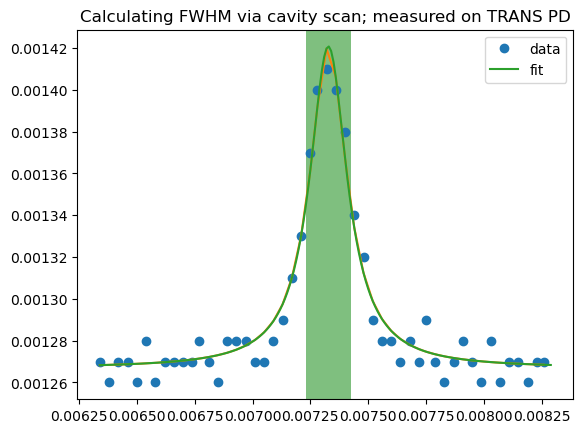

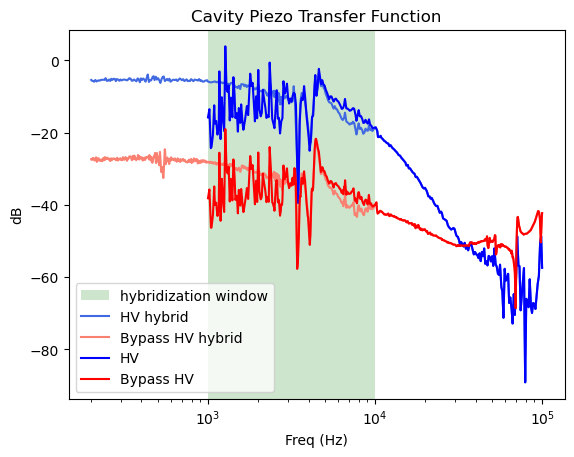

In [43]:

noHV = moku_read_TF_B(r"C:\Users\torre\Downloads\cav_piezo_data\cavitypiezovialaserdirect_20240216_171557_Traces.csv")
HV = moku_read_TF_B(r"C:\Users\torre\Downloads\cav_piezo_data\cavitypiezovialaser_20240216_171339_Traces.csv")
clg = moku_read_TF_A(r"C:\Users\torre\Downloads\cav_piezo_data\cavitylaserclg_20240216_171027_Traces.csv")
cavscan = moku_read_Probe_Points(r"C:\Users\torre\Downloads\cav_piezo_data\cavscan_20240220_113240_Traces.csv")
scan_amp = 1
order = 1
ugf = 15660
pass_band_db = 60


freq_glued,HV_glued,noHV_glued = calc_cav_piezo(cavscan,clg,HV,noHV,scan_amp,order,ugf,pass_band_db)

# thorlabs piezo compressed 

FWHM 0.000865943089162026
BW is: 206528.77839327403
Finesse is: 605.2425282929521


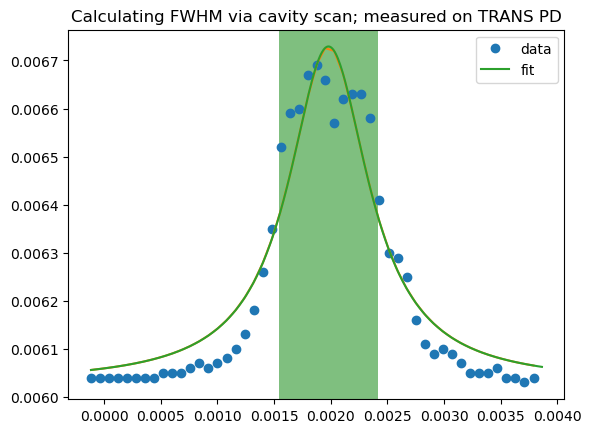

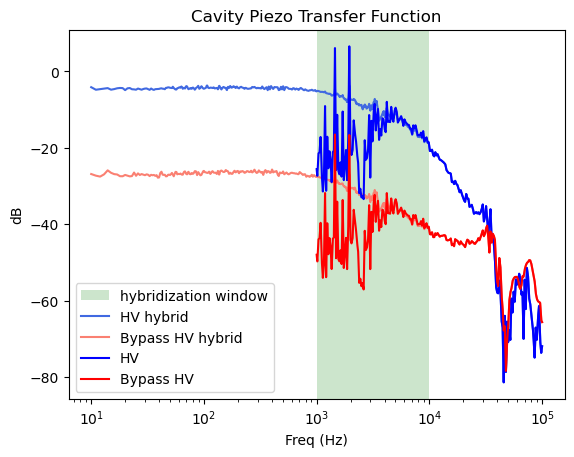

In [42]:
noHV = moku_read_TF_B(r"C:\Users\torre\Downloads\cav_piezo_data\cavpiezovialaserdirect_thorlabscompression_20240227_180754_Traces.csv")
HV = moku_read_TF_B(r"C:\Users\torre\Downloads\cav_piezo_data\cavpiezovialaser_thorlabscompression_20240227_180948_Traces.csv")
clg = moku_read_TF_A(r"C:\Users\torre\Downloads\cav_piezo_data\cavlaserclg_thorlabscompression_20240227_180637_Traces.csv")

cavscan = moku_read_Probe_Points(r"C:\Users\torre\Downloads\cav_piezo_data\cavscan_thorlabscompression_20240227_180524_Traces.csv")
scan_amp = .191
order = 1
ugf = 59900
pass_band_db = 60


freq_compressed, HV_compressed, noHV_compressed = calc_cav_piezo(cavscan,clg,HV,noHV,scan_amp,order,ugf,pass_band_db)

# noaliac piezo

FWHM 0.00033013038116306204
BW is: 189215.2070183294
Finesse is: 660.6234349223905


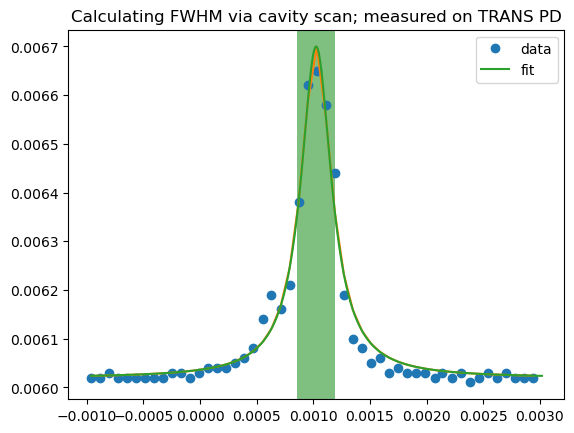

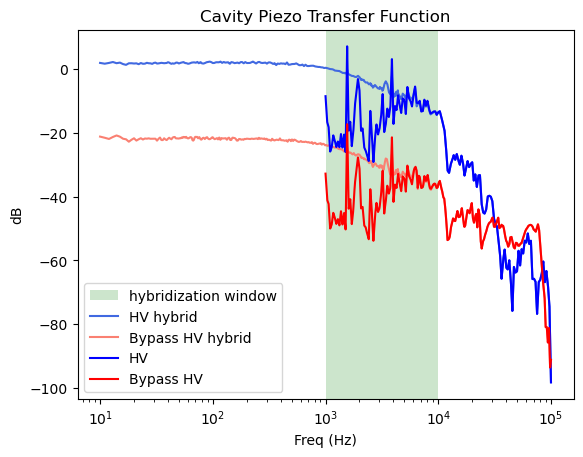

In [44]:
noHV = moku_read_TF_B(r"C:\Users\torre\Downloads\cav_piezo_data\cavitypiezovialaserdirect_noliac_20240227_170432_Traces.csv")
HV = moku_read_TF_B(r"C:\Users\torre\Downloads\cav_piezo_data\cavitypiezovialaser_noliac_20240227_162136_Traces.csv")
clg = moku_read_TF_A(r"C:\Users\torre\Downloads\cav_piezo_data\cavitylaserclg_noliac_20240227_161958_Traces.csv")
cavscan = moku_read_Probe_Points(r"C:\Users\torre\Downloads\cav_piezo_data\cavscan_noliac_20240227_155624_Traces.csv")

scan_amp = .459
order = 1
ugf = 61000
pass_band_db = 60


freq_noaliac,HV_noaliac,noHV_noaliac = calc_cav_piezo(cavscan,clg,HV,noHV,scan_amp,order,ugf,pass_band_db)

FWHM 0.0003828409321132223
BW is: 187396.85168164386
Finesse is: 667.0336181119748


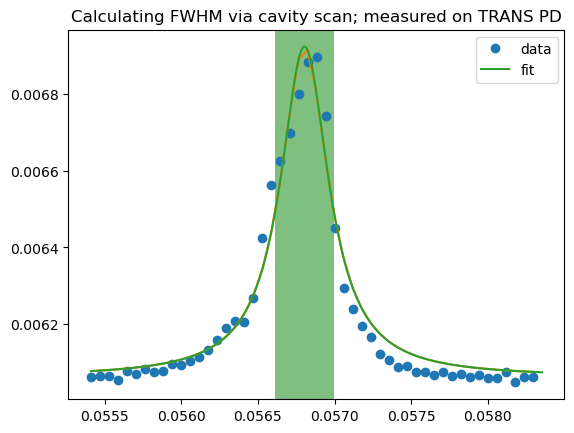

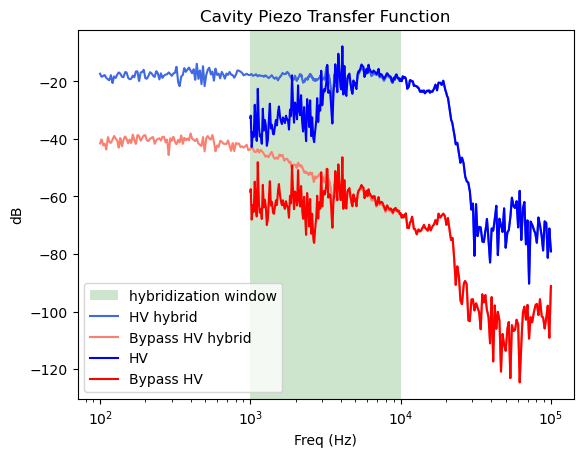

In [45]:
noHV = moku_read_TF_B(r"C:\Users\torre\Downloads\cav_piezo_data\cavitypiezovialaserdirect_smallTL_20240228_153508_Traces.csv")
HV = moku_read_TF_B(r"C:\Users\torre\Downloads\cav_piezo_data\cavitypiezovialaser_smallTL_20240228_153125_Traces.csv")
clg = moku_read_TF_A(r"C:\Users\torre\Downloads\cav_piezo_data\cavclg_smallthorlabs_20240228_152741_Traces.csv")
cavscan = moku_read_Probe_Points(r"C:\Users\torre\Downloads\cav_piezo_data\cavscan_smallTL_20240228_153703_Traces.csv")

scan_amp = .392
order = 1
ugf = 55100 #of fast controller in hz
pass_band_db = 60


freq_smallthorlabs,HV_smallthorlabs,noHV_smallthorlabs = calc_cav_piezo(cavscan,clg,HV,noHV,scan_amp,order,ugf,pass_band_db)

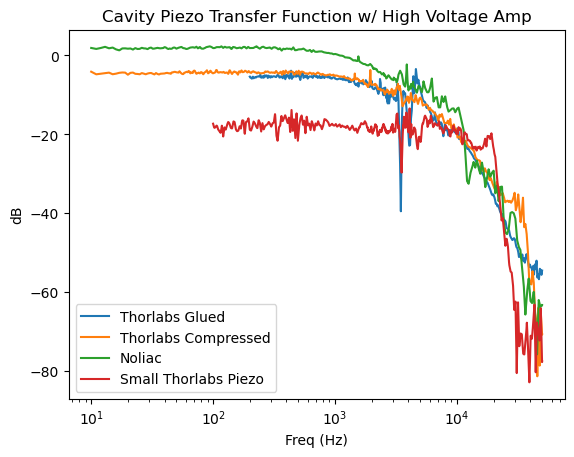

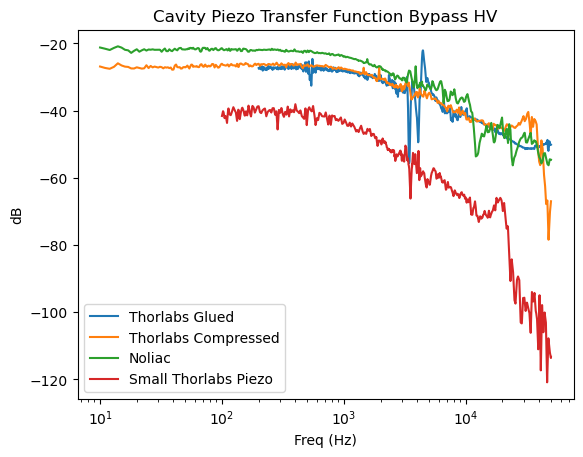

In [46]:
stop_index = 50000
plt.semilogx(freq_glued[:-stop_index],HV_glued[:-stop_index],label = 'Thorlabs Glued')
plt.semilogx(freq_compressed[:-stop_index],HV_compressed[:-stop_index],label = 'Thorlabs Compressed')
plt.semilogx(freq_noaliac[:-stop_index],HV_noaliac[:-stop_index],label = 'Noliac')
plt.semilogx(freq_smallthorlabs[:-stop_index],HV_smallthorlabs[:-stop_index],label = 'Small Thorlabs Piezo')
plt.ylabel('dB')
plt.xlabel('Freq (Hz)')
plt.legend()
plt.title('Cavity Piezo Transfer Function w/ High Voltage Amp')
plt.figure(2)
plt.semilogx(freq_glued[:-stop_index],noHV_glued[:-stop_index],label = 'Thorlabs Glued')
plt.semilogx(freq_compressed[:-stop_index],noHV_compressed[:-stop_index],label = 'Thorlabs Compressed')
plt.semilogx(freq_noaliac[:-stop_index],noHV_noaliac[:-stop_index],label = 'Noliac')
plt.semilogx(freq_smallthorlabs[:-stop_index],noHV_smallthorlabs[:-stop_index], label = 'Small Thorlabs Piezo')
plt.ylabel('dB')
plt.xlabel('Freq (Hz)')
plt.legend()
plt.title('Cavity Piezo Transfer Function Bypass HV')
plt.show()





